In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.sparse import csc_array
import scipy.sparse.linalg as spla

import matplotlib.pyplot as plt
import matplotlib as mpl

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

from qs_mps.applications.Z2.exact_hamiltonian import *
from qs_mps.sparse_hamiltonians_and_operators import diagonalization, sparse_pauli_x, sparse_pauli_z, sparse_ising_hamiltonian, evolution_operator, sparse_magnetization
from qs_mps.mps_class import MPS
from qs_mps.utils import anim, get_cx, get_cy

# Ising Time Evolution

We evolve the ground state of a Ising Hamiltonian to another state, through a Quench, that is, the state to evolve is not an eigenstate of the Hamiltonian used as time evolving operator $U(t)$

In [2]:
L = 4
J = 1
h_t = 1e-5
h_l = 0

H_i = sparse_ising_hamiltonian(J=J, h_l=h_l, h_t=h_t, L=L, long="Z")
e, v = diagonalization(H_i, sparse=False)
psi0 = v[:,0]
(psi0.conjugate() @ psi0)

(1.0000000000000002+0j)

In [3]:
M = sparse_magnetization(L=L, op="Z")
print(psi0.shape)
print(M.nonzero())
psi0.conjugate() @ M @ psi0

(16,)
(array([ 0,  1,  2,  4,  7,  8, 11, 13, 14, 15]), array([ 0,  1,  2,  4,  7,  8, 11, 13, 14, 15]))


(0.9999999999570345+0j)

## Test of operators - no trotter error

In [4]:
delta = 0.01
steps = 10
H_ev = sparse_ising_hamiltonian(J=0, h_l=0, h_t=1, L=L)
U_trans = spla.expm(-1j*delta*H_ev)
psi_ev_trott = psi0.copy()

ex_sp = []
for trott in range(steps):
    U_ev = spla.expm(-1j*delta*(trott+1)*H_ev)
    psi_ev_ex = U_ev @ psi0

    psi_ev_trott = U_trans @ psi_ev_trott
    ex_sp.append(psi_ev_ex.conjugate() @ psi_ev_trott)

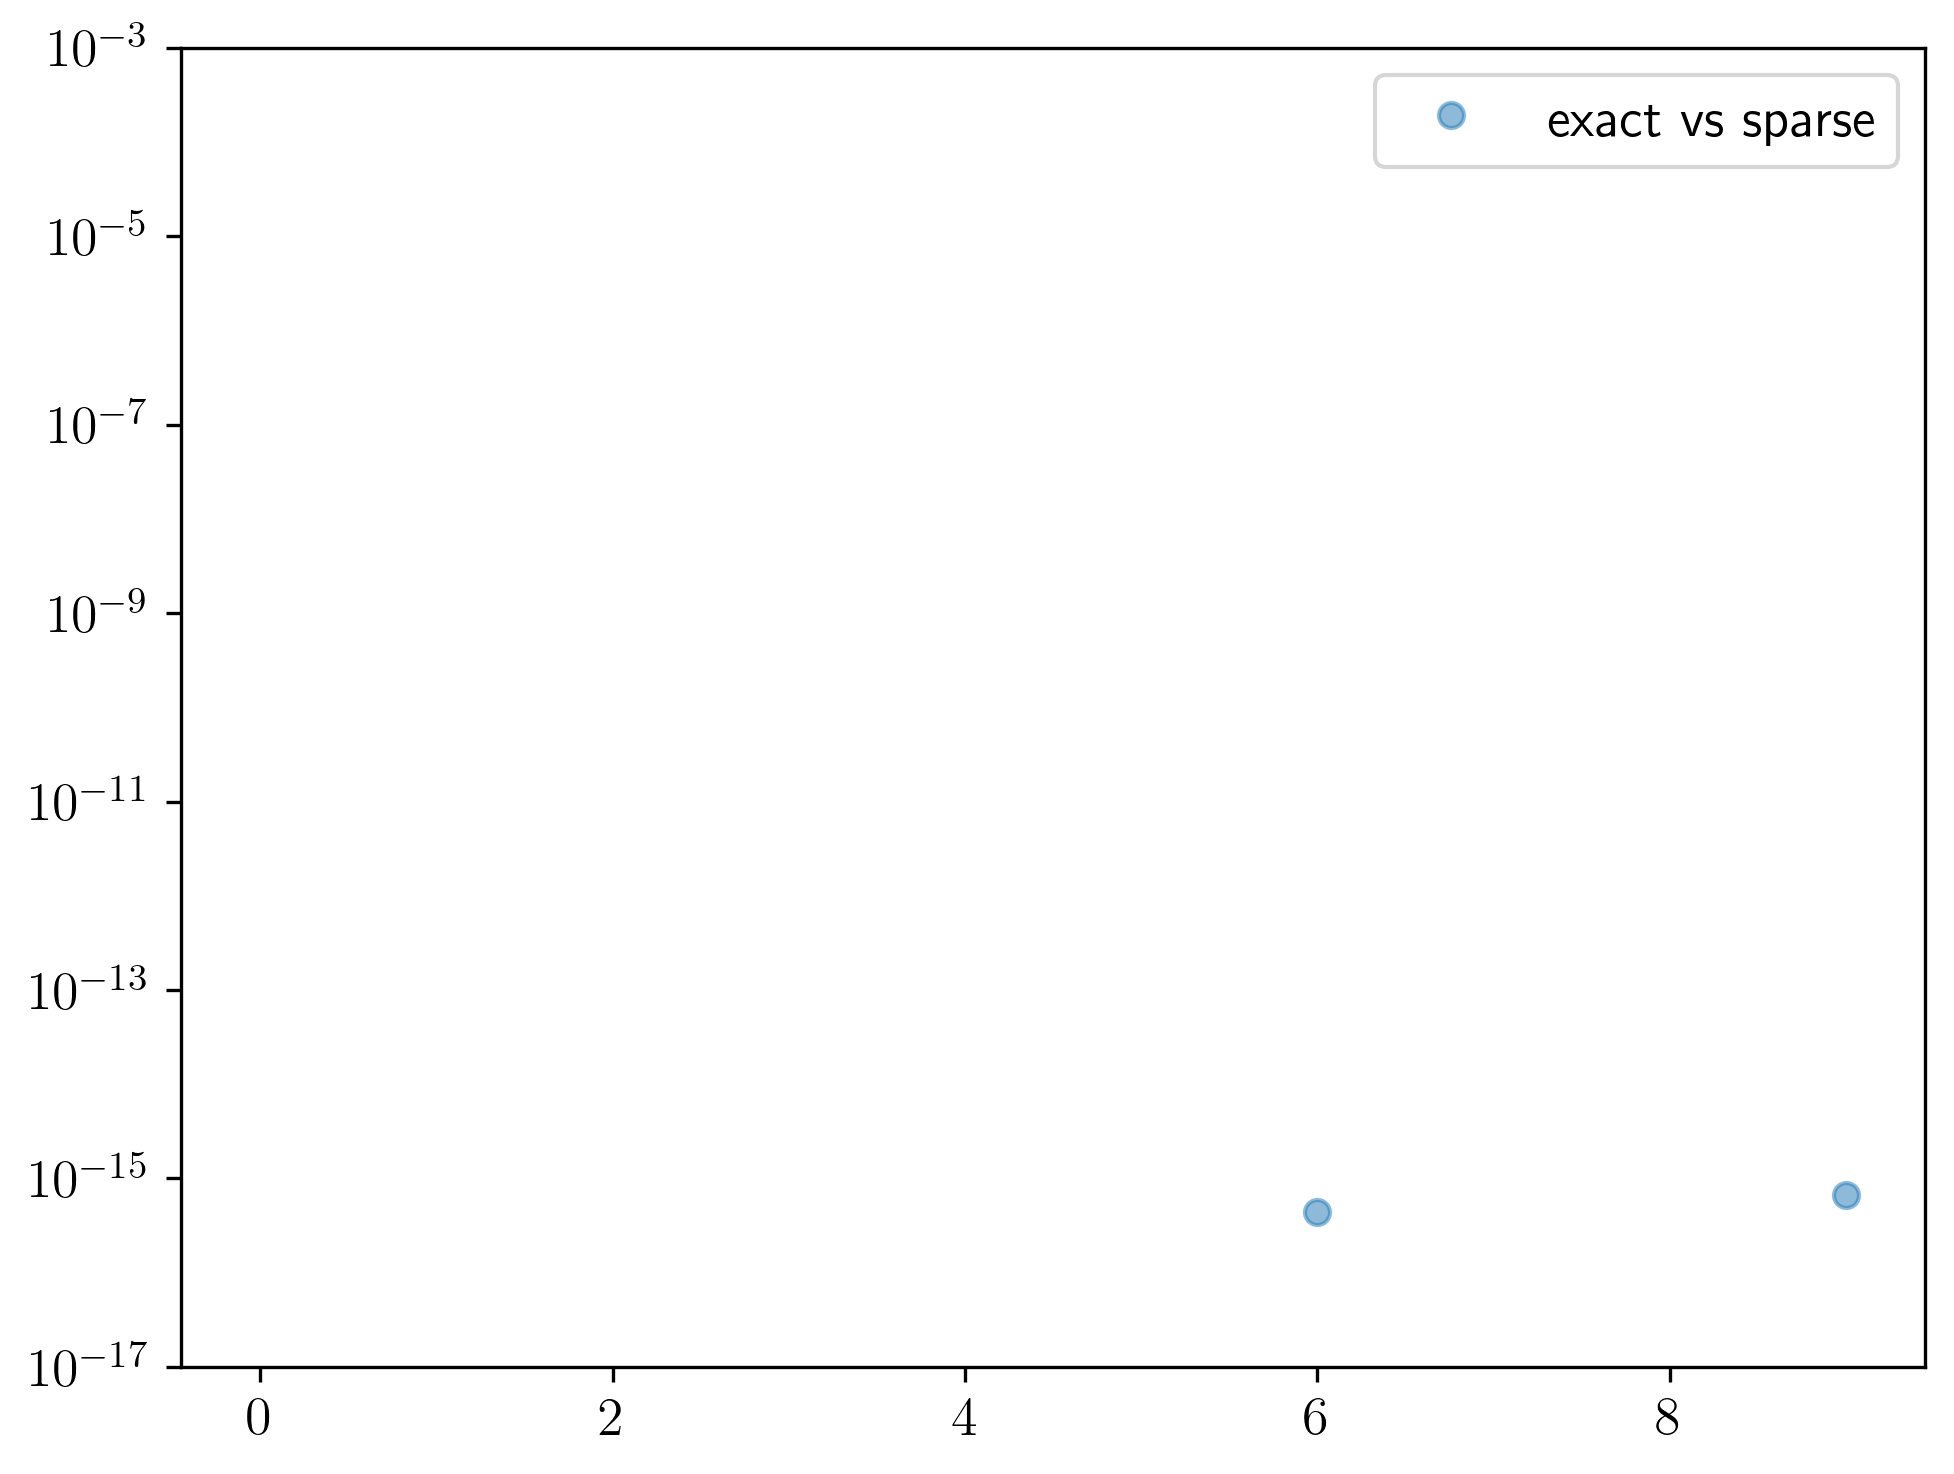

In [5]:
plt.plot([1-(ex_sp[i].real**2+ex_sp[i].imag**2) for i in range(steps)], marker='o', linestyle="", alpha=0.5, label="exact vs sparse")
plt.yscale("log")
plt.ylim(top=1e-3, bottom=1e-17)
plt.legend()

## Test of operators - trotter error

In [6]:
delta = 0.01
steps = 10
J_ev, h_ev = 1, 1
H_ev = sparse_ising_hamiltonian(J=J_ev, h_l=0, h_t=h_ev, L=L, long="Z")
H_ev_loc = sparse_ising_hamiltonian(J=0, h_l=0, h_t=h_ev, L=L, long="Z")
U_loc = spla.expm(-1j*delta/2*H_ev_loc)
H_ev_int = sparse_ising_hamiltonian(J=J_ev, h_l=0, h_t=0, L=L, long="Z")
U_int = spla.expm(-1j*delta*H_ev_int)
U_trott = U_loc @ U_int @ U_loc
psi_ev_trott = psi0.copy()

ex_sp = []
for trott in range(steps):
    print(f"Trotter step: {trott}")
    U_ev = spla.expm(-1j*delta*(trott+1)*H_ev)
    psi_ev_ex = U_ev @ psi0

    psi_ev_trott = U_trott @ psi_ev_trott
    ex_sp.append(psi_ev_ex.conjugate() @ psi_ev_trott)

Trotter step: 0
Trotter step: 1
Trotter step: 2
Trotter step: 3
Trotter step: 4
Trotter step: 5
Trotter step: 6
Trotter step: 7
Trotter step: 8
Trotter step: 9


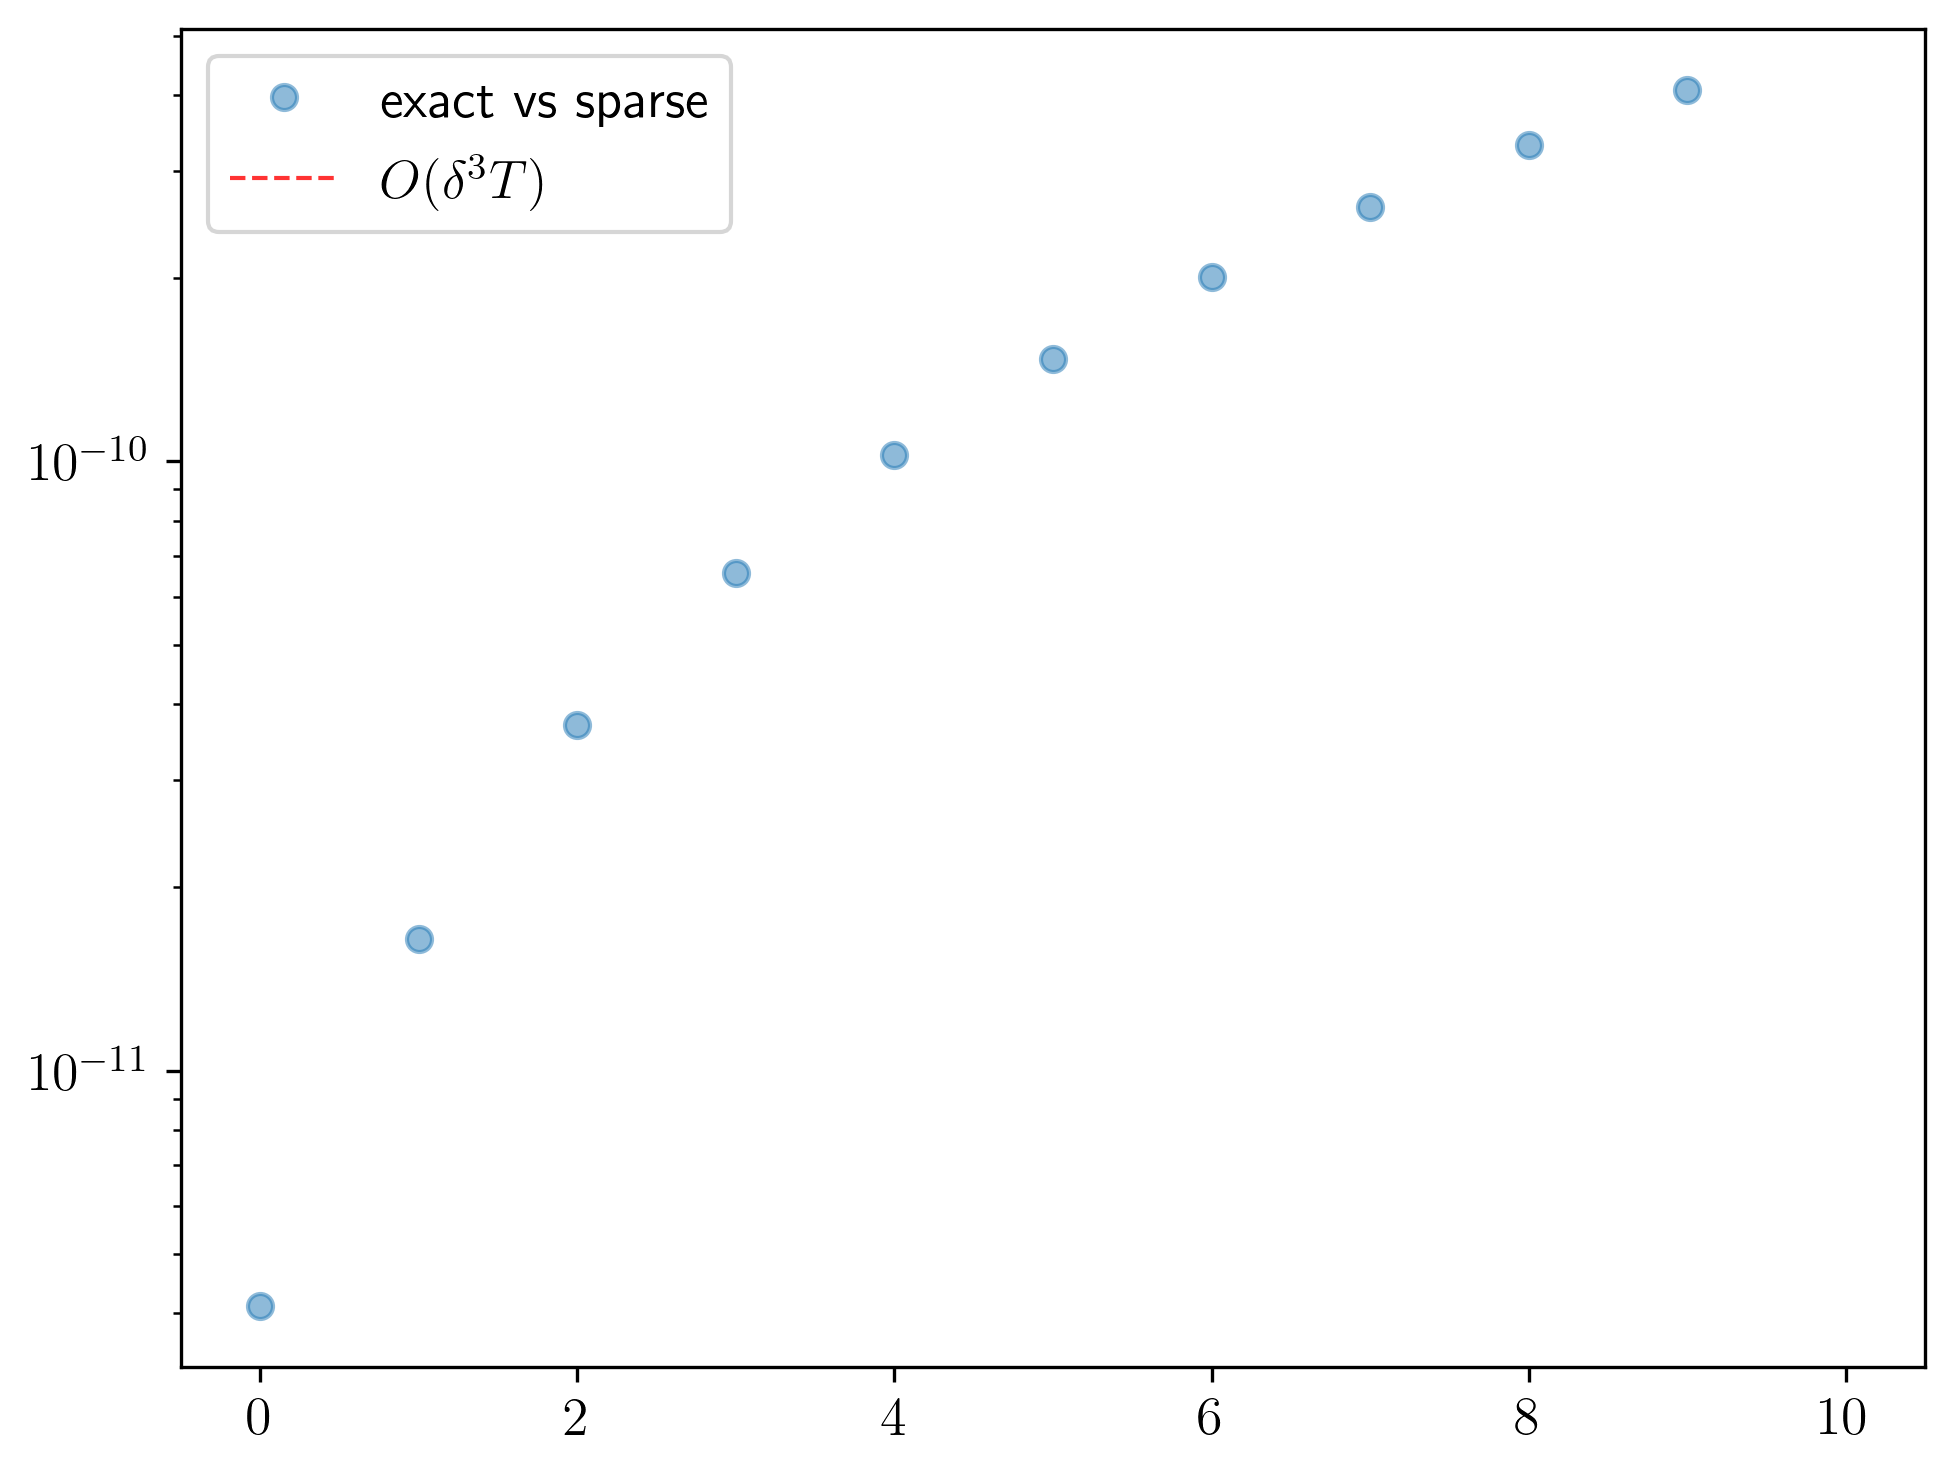

In [7]:
plt.plot([1-(ex_sp[i].real**2+ex_sp[i].imag**2) for i in range(steps)], marker='o', linestyle="", alpha=0.5, label="exact vs sparse")
plt.yscale("log")
# plt.ylim(top=1e1, bottom=1e-8)
plt.hlines(y=delta**3*steps, xmin=0, xmax=steps, linestyles="--", linewidth=1, alpha=0.8, color="red", label="$O(\\delta^3 T)$")
plt.legend()

## TEBD with variational compression

Initialize the MPS to find the ground state through DMRG

In [8]:
L = 4
d = 2
model = "Ising"
J = 1
h_t = 1e-7
h_l = 0
chi = 50

ising_chain = MPS(L=L, d=d, model=model, chi=chi, J=J, h=h_t, eps=h_l)
ising_chain._random_state(seed=3, type_shape="rectangular", chi=chi)
ising_chain.canonical_form()
ising_chain.DMRG(trunc_chi=True, trunc_tol=False, where=L//2, long="Z", trans="X")
ising_chain.check_canonical(site=1)

Sweep n: 0

Sweep n: 1

the tensor at site 4 is in the correct RFC
the tensor at site 3 is in the correct RFC
the tensor at site 2 is in the correct RFC


In [9]:
ising_chain.order_param()
ising_chain.mpo_first_moment()

array(-4.+0.j)

In [10]:
delta = 0.01
steps = 50
ex_sp, ex_mps, mps_sp = ising_chain.TEBD_variational_Ising_debug(trotter_steps=steps, delta=delta, h_ev=h_ev, J_ev=J_ev, where=L//2)


## Norm of psi0_mps:  (1.0000000000000004+0j)

## Norm of psi0_ex:  (1.0000000000000002+0j)

## Norm of psi0_sp:  (1.0000000000000002+0j)
------ Trotter steps: 0 -------
Bond dim site: 4
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-12 after:
1 sweeps at site 3
total iterations 7
##############################
MPO matches the sparse matrix representation!
the tensor at site 4 is in the correct RFC
the tensor at site 3 is in the correct RFC
the tensor at site 2 is in the correct RFC
Difference for exact: 6.531531753670423e-06
------ Trotter steps: 1 -------
Bond dim site: 4
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-12 after:
1 sweeps at site 3
total iterations 7
##############################
MPO matches the sparse matrix representation!
the tensor at site 4 is in the correct RFC
the tensor at site 3 is in the correct 

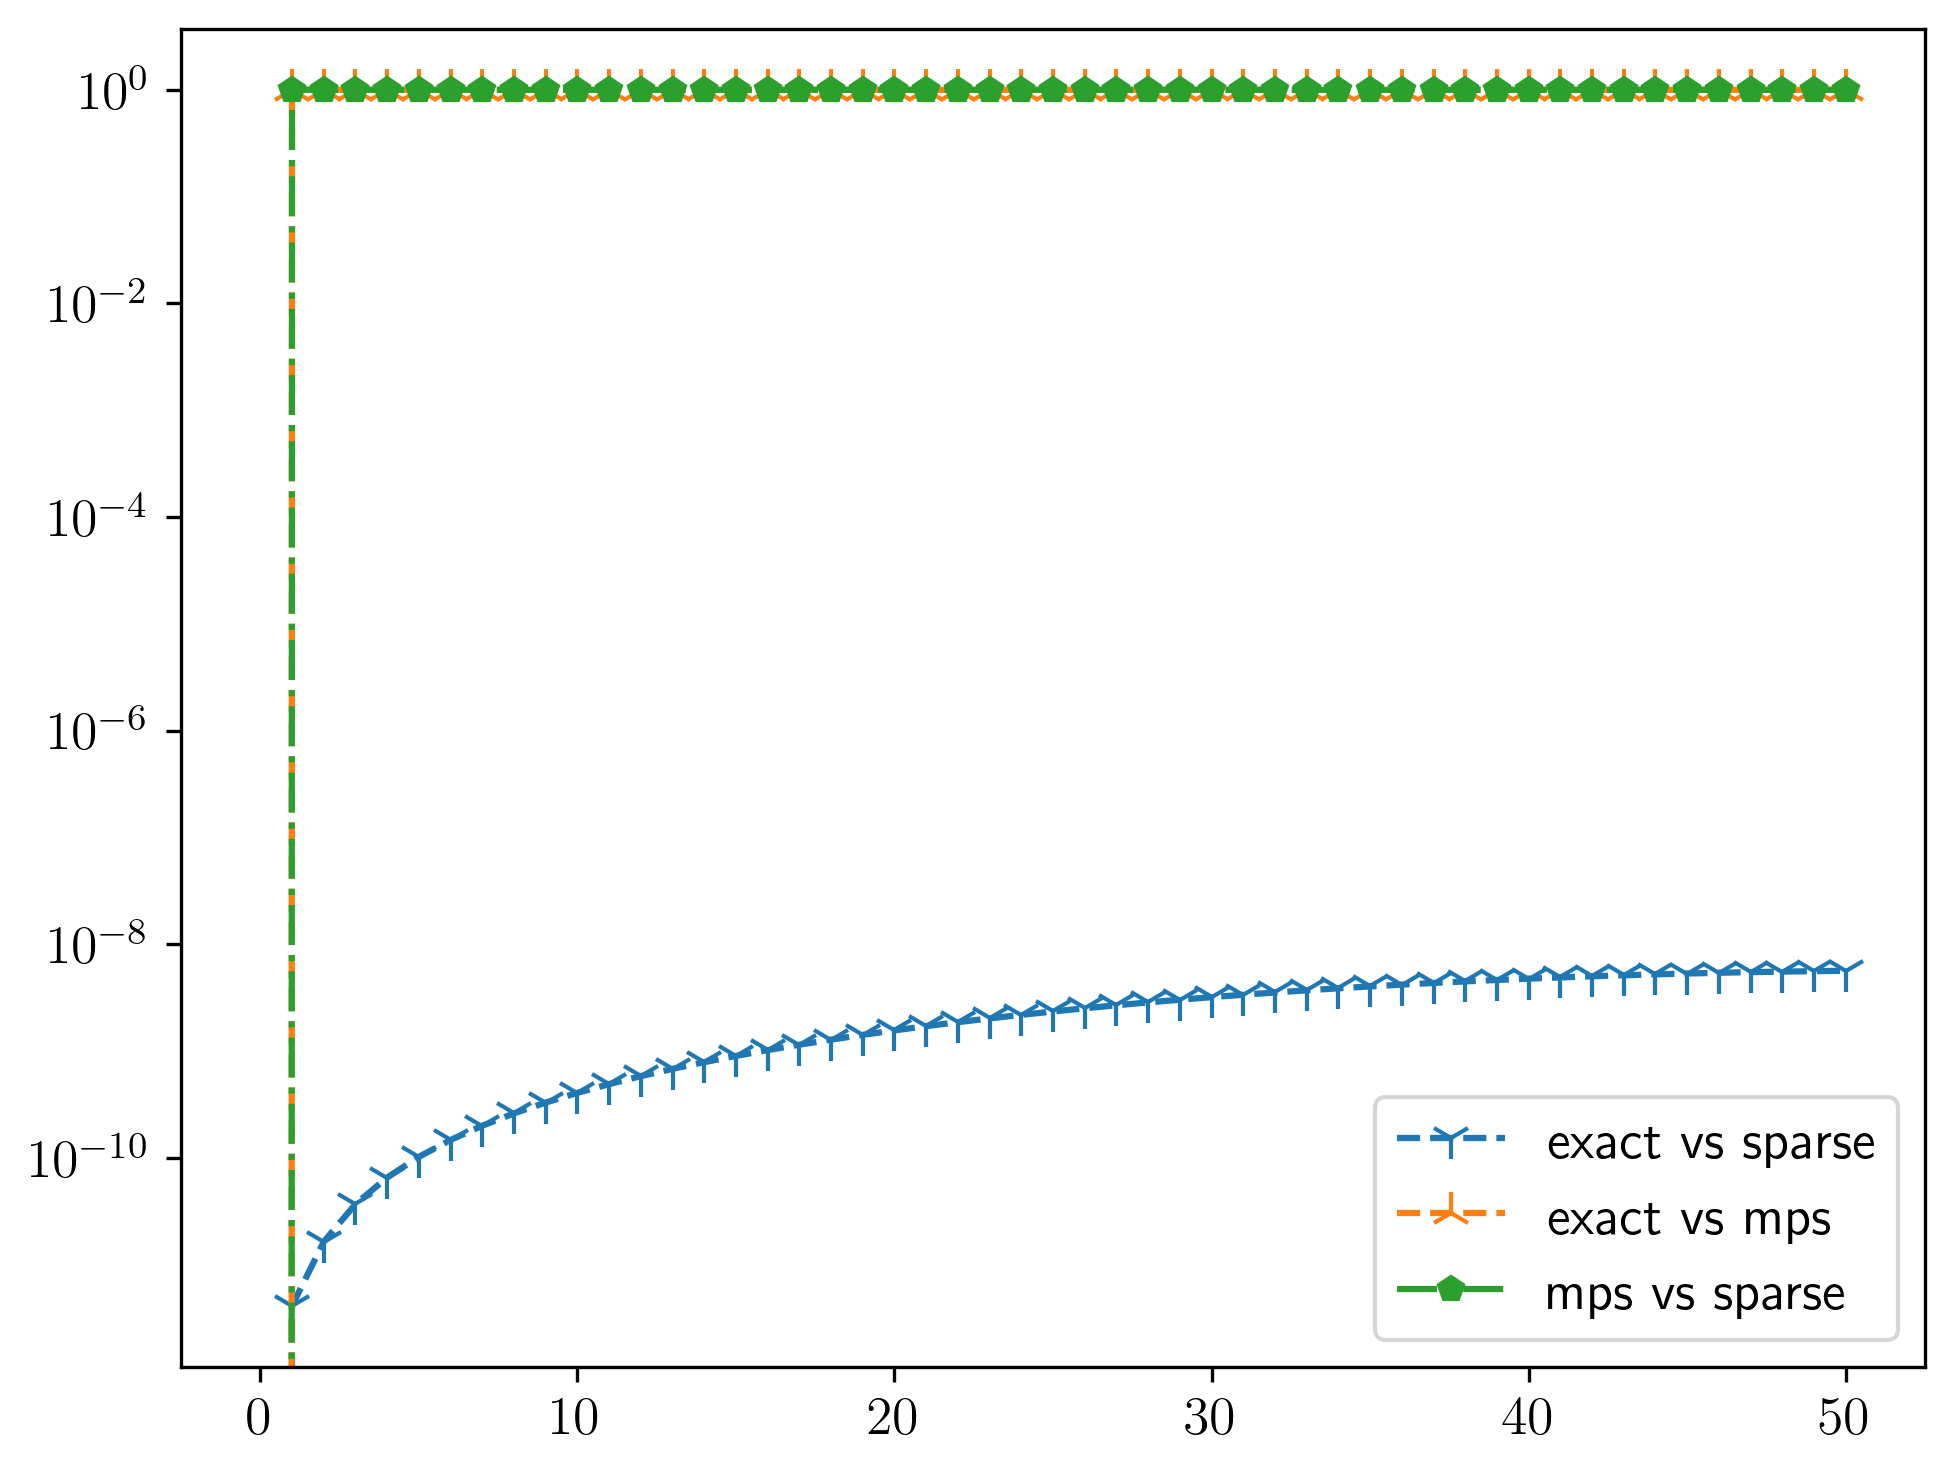

In [11]:
plt.plot([1-(ex_sp[i].real**2+ex_sp[i].imag**2) for i in range(steps+1)], linestyle='--', marker='1', markersize=10, label="exact vs sparse")
plt.plot([1-(ex_mps[i].real**2+ex_mps[i].imag**2) for i in range(steps+1)], linestyle='--', marker='2', markersize=10, label="exact vs mps")
plt.plot([1-(mps_sp[i].real**2+mps_sp[i].imag**2) for i in range(steps+1)], linestyle='-.', marker='p', label="mps vs sparse")
plt.yscale("log")
plt.legend()

In [12]:
ising_chain.mpo_Ising_quench_global(delta=delta, h_ev=h_ev, J_ev=J_ev)
ising_ev_mpo = ising_chain.w.copy()
matrix_ising_ev_mpo = mpo_to_matrix(ising_ev_mpo)
matrix_ising_ev_mpo.shape

(16, 16)

In [13]:
difference = np.linalg.norm(matrix_ising_ev_mpo - U_trott.toarray())
if difference < 1e-10:  # Threshold for numerical precision
    print("MPO matches the sparse matrix representation!")
else:
    print(f"Mismatch found! Difference: {difference}")

MPO matches the sparse matrix representation!


### Debug Ising ev mpo

In [14]:
I = np.eye(2)
O = np.zeros((2, 2))
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
w_tot_int = []
w_tot_loc = []
w_loc = np.array(spla.expm(1j * h_ev * delta / 2 * X)).reshape((1,1,2,2))

w_left = np.array([[np.sqrt(np.cos(delta*J_ev))*I,1j*np.sqrt(np.sin(delta*J_ev))*Z]])
w_right = np.array([[np.sqrt(np.cos(delta*J_ev))*I],[np.sqrt(np.sin(delta*J_ev))*Z]])
w_bulk = np.array([[np.cos(delta*J_ev)*I        ,       1J*np.sqrt(np.sin(delta*J_ev)*np.cos(delta*J_ev))*Z],
                   [np.sqrt(np.sin(delta*J_ev)*np.cos(delta*J_ev))*Z     ,       1j*np.sin(delta*J_ev)*I]])
print(w_left.shape, w_right.shape, w_bulk.shape, w_loc.shape)

for site in range(L):
    if site == 0:
        w_tot_int.append(w_left)
    elif site == L-1:
        w_tot_int.append(w_right)
    else:
        w_tot_int.append(w_bulk)
    w_tot_loc.append(w_loc)

matrix_int_mpo = mpo_to_matrix(w_tot_int)
matrix_loc_mpo = mpo_to_matrix(w_tot_loc)

(1, 2, 2, 2) (2, 1, 2, 2) (2, 2, 2, 2) (1, 1, 2, 2)


In [15]:
J_ev, h_ev = 1, 1
H_ev = sparse_ising_hamiltonian(J=J_ev, h_l=0, h_t=h_ev, L=L, long="Z")
H_ev_loc = sparse_ising_hamiltonian(J=0, h_l=0, h_t=h_ev, L=L, long="Z")
U_loc = spla.expm(-1j*delta/2*H_ev_loc)
H_ev_int = sparse_ising_hamiltonian(J=J_ev, h_l=0, h_t=0, L=L, long="Z")
U_int = spla.expm(-1j*delta*H_ev_int)
U_trott = U_loc @ U_int @ U_loc

In [16]:
difference = np.linalg.norm(matrix_int_mpo - U_int.toarray())
if difference < 1e-10:  # Threshold for numerical precision
    print("MPO matches the sparse matrix representation!")
else:
    print(f"Mismatch found! Difference: {difference}")

MPO matches the sparse matrix representation!


In [17]:
difference = np.linalg.norm(matrix_loc_mpo - U_loc.toarray())
if difference < 1e-10:  # Threshold for numerical precision
    print("MPO matches the sparse matrix representation!")
else:
    print(f"Mismatch found! Difference: {difference}")

MPO matches the sparse matrix representation!


In [18]:
difference = np.linalg.norm(matrix_int_mpo - U_int.toarray())
if difference < 1e-10:  # Threshold for numerical precision
    print("MPO matches the sparse matrix representation!")
else:
    print(f"Mismatch found! Difference: {difference}")

MPO matches the sparse matrix representation!


Ising defect

In [ ]:
L = 9
H_ev = sparse_ising_hamiltonian(J=1, h_t=0.2, h_l=0, L=L, long="Z")
psi0 = np.zeros((2**L,1))
psi0[0] = 1
M = sparse_magnetization(L=L, op = "Z")
print(psi0.T.conjugate() @ M @ psi0)

loc_mag = []
for i in range(L):
    loc_mag.append(psi0.T.conjugate() @ sparse_pauli_z(n=i, L=L) @ psi0)

print(loc_mag)

flip_state = sparse_pauli_x(n=L//2, L=L) @ psi0

loc_mag = []
for i in range(L):
    loc_mag.append(flip_state.T.conjugate() @ sparse_pauli_z(n=i, L=L) @ flip_state)

print(loc_mag)


[[1.+0.j]]
[array([[1.+0.j]]), array([[1.+0.j]]), array([[1.+0.j]]), array([[1.+0.j]]), array([[1.+0.j]]), array([[1.+0.j]]), array([[1.+0.j]]), array([[1.+0.j]]), array([[1.+0.j]])]
[array([[1.+0.j]]), array([[1.+0.j]]), array([[1.+0.j]]), array([[1.+0.j]]), array([[-1.+0.j]]), array([[1.+0.j]]), array([[1.+0.j]]), array([[1.+0.j]]), array([[1.+0.j]])]


In [25]:
trotter_steps = 100
delta = 0.01
psi_ev = flip_state.copy()

for T in range(trotter_steps):
    print(f"trotter step: {T+1}")
    t = (T+1) * delta
    U = evolution_operator(t, H_ev)
    psi_ev = U @ psi_ev
    for i in range(L):
        loc_mag.append(psi_ev.T.conjugate() @ sparse_pauli_z(n=i, L=L) @ psi_ev)

trotter step: 1
trotter step: 2
trotter step: 3
trotter step: 4
trotter step: 5
trotter step: 6
trotter step: 7
trotter step: 8
trotter step: 9
trotter step: 10
trotter step: 11
trotter step: 12
trotter step: 13
trotter step: 14
trotter step: 15
trotter step: 16
trotter step: 17
trotter step: 18
trotter step: 19
trotter step: 20
trotter step: 21
trotter step: 22
trotter step: 23
trotter step: 24
trotter step: 25
trotter step: 26
trotter step: 27
trotter step: 28
trotter step: 29
trotter step: 30
trotter step: 31
trotter step: 32
trotter step: 33
trotter step: 34
trotter step: 35
trotter step: 36
trotter step: 37
trotter step: 38
trotter step: 39
trotter step: 40
trotter step: 41
trotter step: 42
trotter step: 43
trotter step: 44
trotter step: 45
trotter step: 46
trotter step: 47
trotter step: 48
trotter step: 49
trotter step: 50
trotter step: 51
trotter step: 52
trotter step: 53
trotter step: 54
trotter step: 55
trotter step: 56
trotter step: 57
trotter step: 58
trotter step: 59
trotte

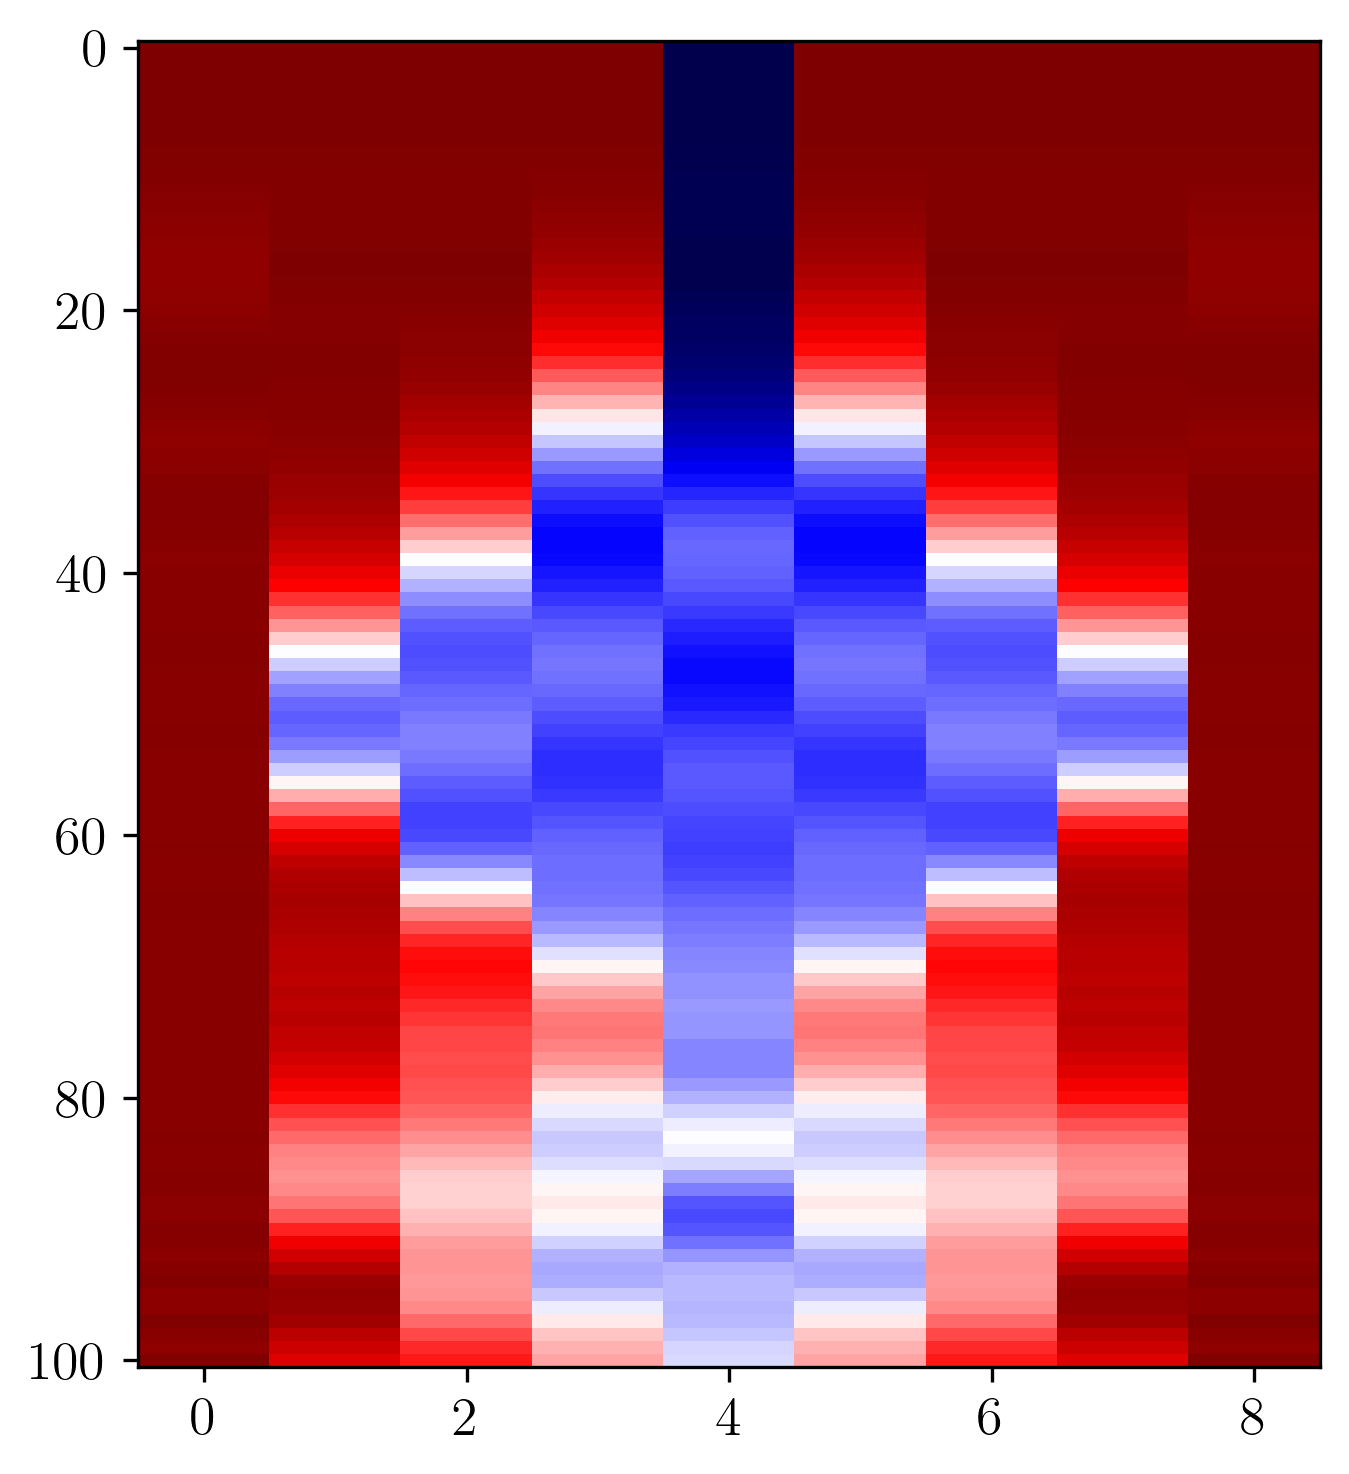

In [38]:
matrix = np.asarray(loc_mag).reshape((101,9))
plt.imshow(matrix.real, cmap='seismic', aspect=0.1)